# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import random

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import shuffle
from tqdm import tqdm
from utils import mape, mean_std_cross_val_scores
from xgboost import XGBClassifier, XGBRegressor

from extrucal.extrusion import throughput_cal

random.seed(0)

# 1. Dataset Read In

In [2]:
df = pd.read_csv("../data/dataset_generated_by_extrucal.csv")
df

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
0,110,9.9,1100,70,198.0,6.6,1,1098.589031
1,200,6.0,1200,20,280.0,24.0,1,570.539214
2,170,3.4,900,10,204.0,17.0,1,80.381221
3,40,3.6,1400,50,32.0,4.8,2,16.562224
4,120,10.8,1200,20,144.0,16.8,1,302.226196
...,...,...,...,...,...,...,...,...
1505275,250,20.0,1300,0,150.0,25.0,2,0.000000
1505276,170,5.1,900,80,204.0,23.8,2,725.163605
1505277,100,8.0,1000,40,180.0,10.0,1,367.109598
1505278,60,2.4,900,10,84.0,3.6,2,7.367364


In [3]:
# Apply log-transformation to target
df["log_throughput"] = np.log1p(df["throughput"])

# 2. Train/Test Split

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput,log_throughput
740665,70,4.9,1300,50,84.0,4.2,2,120.867172,4.802932
164740,250,7.5,1100,20,200.0,50.0,1,534.042645,6.282346
250675,190,15.2,1400,40,304.0,34.2,2,2499.008358,7.824049
1371460,250,22.5,1400,70,150.0,20.0,2,4149.319256,8.330941
1356849,70,1.4,1200,40,56.0,14.0,1,16.814445,2.880010


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204224 entries, 740665 to 773630
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   extruder_size    1204224 non-null  int64  
 1   metering_depth   1204224 non-null  float64
 2   polymer_density  1204224 non-null  int64  
 3   rpm              1204224 non-null  int64  
 4   screw_pitch      1204224 non-null  float64
 5   flight_width     1204224 non-null  float64
 6   number_flight    1204224 non-null  int64  
 7   throughput       1204224 non-null  float64
 8   log_throughput   1204224 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 91.9 MB


In [6]:
X_train = train_df.drop(columns=["throughput", "log_throughput"])
y_train = train_df["log_throughput"]

X_test = test_df.drop(columns=["throughput", "log_throughput"])
y_test = test_df["log_throughput"]

# 3. Preparation of Preprocessors

In [7]:
no_log_features = ["extruder_size", "polymer_density", "rpm", "number_flight"]
log_features = ["metering_depth", "screw_pitch", "flight_width"]

In [8]:
no_log_transformer = make_pipeline(
    StandardScaler(),
)

In [9]:
log_transformer = make_pipeline(
    FunctionTransformer(np.log1p),
    StandardScaler(),
)

In [10]:
preprocessor = make_column_transformer(
    (no_log_transformer, no_log_features), (log_transformer, log_features)
)

# 4. Cross-Validation of ML Models

In [11]:
results = {}

In [12]:
mape_scorer = make_scorer(mape, greater_is_better=False)

## 4.1. Baseline Model

In [13]:
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

In [14]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy,
    X_train,
    y_train,
    return_train_score=True,
    scoring="neg_mean_squared_error",
)

In [15]:
pd.DataFrame(results)

,Dummy
fit_time,0.211 (+/- 0.017)
score_time,0.027 (+/- 0.002)
test_score,-6.718 (+/- 0.006)
train_score,-6.718 (+/- 0.002)


## 4.2. ML Models

In [16]:
random_state = 123

pipe_ridge = make_pipeline(
    preprocessor, Ridge(max_iter=2000, random_state=random_state)
)
pipe_lasso = make_pipeline(
    preprocessor, Lasso(max_iter=2000, random_state=random_state)
)
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(random_state=random_state))
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=random_state, verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    preprocessor,
    CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE"),
)

In [17]:
models = {
    "ridge": pipe_ridge,
    "lass": pipe_lasso,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [18]:
%%time

for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        return_train_score=True,
        scoring="neg_mean_squared_error",
    )

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [34:23<00:00, 343.91s/it]

CPU times: total: 1h 37min 3s
Wall time: 34min 23s


In [19]:
pd.DataFrame(results)

,Dummy,ridge,lass,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.211 (+/- 0.017),0.280 (+/- 0.015),0.500 (+/- 0.021),264.935 (+/- 13.217),25.394 (+/- 2.658),3.337 (+/- 0.495),60.590 (+/- 2.407)
score_time,0.027 (+/- 0.002),0.040 (+/- 0.005),0.037 (+/- 0.003),10.724 (+/- 0.869),0.174 (+/- 0.015),0.355 (+/- 0.057),0.091 (+/- 0.010)
test_score,-6.718 (+/- 0.006),-1.609 (+/- 0.005),-3.831 (+/- 0.005),-0.002 (+/- 0.000),-0.005 (+/- 0.000),-0.006 (+/- 0.000),-0.001 (+/- 0.000)
train_score,-6.718 (+/- 0.002),-1.609 (+/- 0.001),-3.831 (+/- 0.002),-0.000 (+/- 0.000),-0.005 (+/- 0.000),-0.006 (+/- 0.000),-0.001 (+/- 0.000)


#### `CatBoost` seems to perform best

# 5. Evaluation of `CatBoost` Model

In [20]:
%%time

pipe_catb.fit(X_train, y_train)

CPU times: total: 11min 5s
Wall time: 1min 12s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['extruder_size',
                                                   'polymer_density', 'rpm',
                                                   'number_flight']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['metering_depth',
   

## 5.1. Comparison between Prediction and `y_test`

In [21]:
y_pred = np.expm1(pipe_catb.predict(X_test))

In [22]:
y_test = np.expm1(y_test)

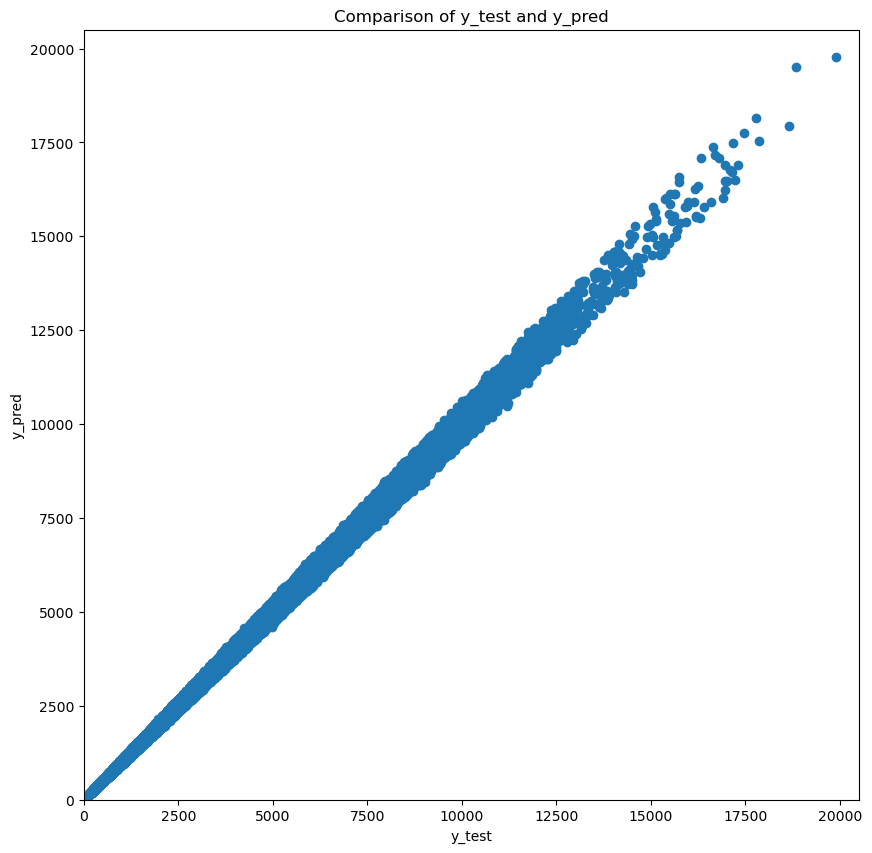

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.show();

In [24]:
mape(y_test, y_pred)

3.3936326177300296

## 5.2. Comparison with `extrucal` results

In [25]:
extruder_size = []
for i in range(25, 251, 25):
    extruder_size.extend([i] * 10)

metering_depth_percent = [0.05] * 100
polymer_density = [1000] * 100
screw_pitch_percent = [1] * 100
flight_width_percent = [0.1] * 100
number_flight = [1] * 100
rpm = [r for r in range(0, 92, 10)] * 10

In [26]:
df = pd.DataFrame(
    {
        "extruder_size": extruder_size,
        "metering_depth_percent": metering_depth_percent,
        "polymer_density": polymer_density,
        "screw_pitch_percent": screw_pitch_percent,
        "flight_width_percent": flight_width_percent,
        "number_flight": number_flight,
        "rpm": rpm,
    }
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size",
    "metering_depth",
    "polymer_density",
    "rpm",
    "screw_pitch",
    "flight_width",
    "number_flight",
]

df = df[new_col_order]
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight
0,25,1.25,1000,0,25,2.5,1
1,25,1.25,1000,10,25,2.5,1
2,25,1.25,1000,20,25,2.5,1
3,25,1.25,1000,30,25,2.5,1
4,25,1.25,1000,40,25,2.5,1


In [27]:
df["CatBoost_model"] = np.expm1(pipe_catb.predict(df))

In [28]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"]),
    ),
    axis=1,
)

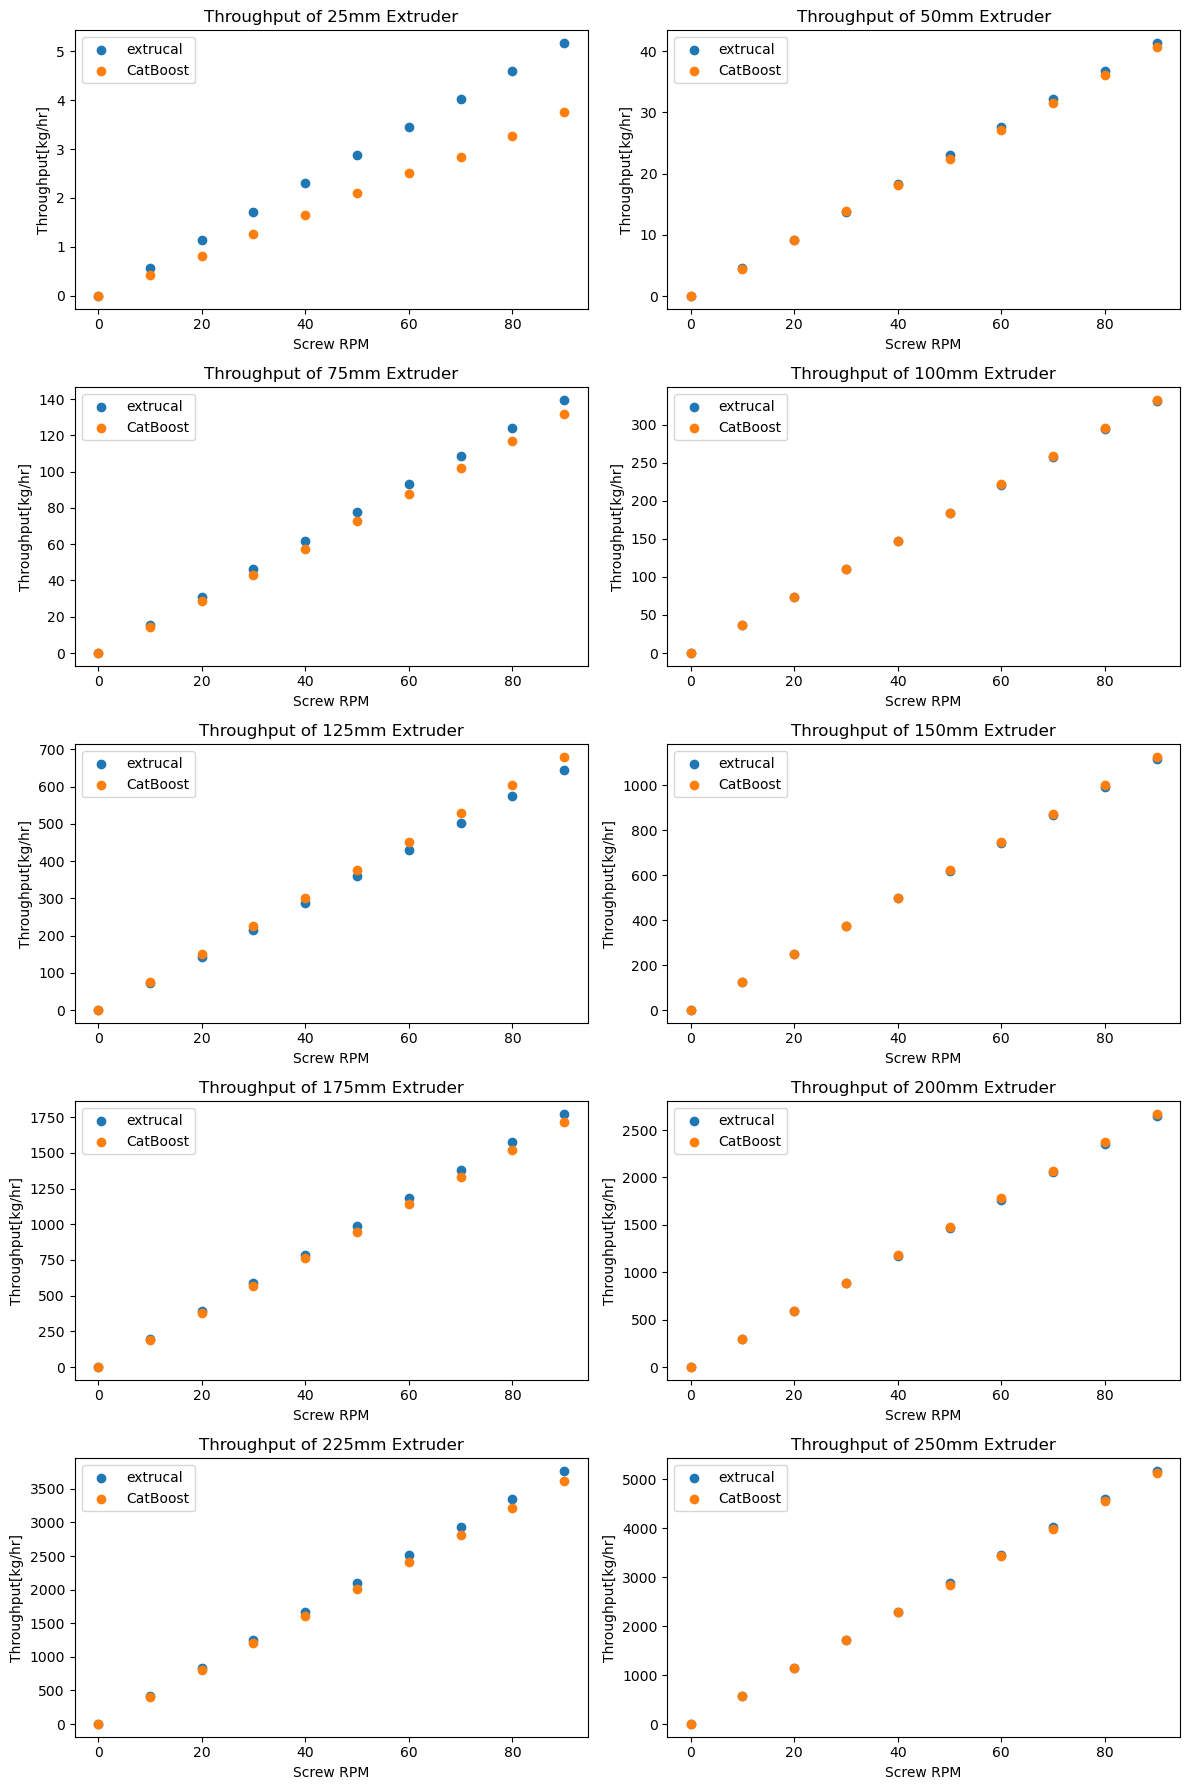

In [29]:
fig, axs = plt.subplots(figsize=(12, 18), nrows=5, ncols=2)
r = 0
c = 0
for size in list(df["extruder_size"].unique()):
    temp = df.query(f"extruder_size == {size}")
    axs[r, c].scatter(temp["rpm"], temp["extrucal"], label="extrucal")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_model"], label="CatBoost")
    axs[r, c].set_title(f"Throughput of {size}mm Extruder")
    axs[r, c].set_xlabel("Screw RPM")
    axs[r, c].set_ylabel("Throughput[kg/hr]")
    axs[r, c].legend()
    if c < 1:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

The disparity between `extrucal` and `CatBoost` for the throughputs in small sized extruder (i.e. 25mm extruder) is considerably bigger than those for the bigger sized extruders (i.e., > 50mm extruder).